In [1]:
import pandas as pd
import numpy as np 

import sys
sys.path.append('../../Function/')
import function

from keras.layers import Dense, Dropout
from keras.models import Sequential


In [2]:
df = pd.read_excel('../../../site_info_ver_5.xlsx')

In [3]:
dataset = df.copy()
sites = dataset.Site_Name.unique()
site_name = 'Tel Arad'
target = 'Israelis_Count'
target_title = 'Israelis'
dataset = dataset.loc[dataset.Site_Name==site_name]
dataset = dataset.loc[dataset[target]<2000]

dataset = dataset.drop(['Total','Tourists_Count'],axis=1)
dataset = function.remove_pollution_site(dataset)
dataset = dataset.drop(dataset.filter(regex='nox').columns, axis=1)
dataset = dataset.drop(dataset.filter(regex='so2').columns, axis=1)
print('model on site',site_name)
print('Focus on ',target_title)

# dataset = function.remove_outliers(dataset, target)

dataset = function.remove_unique_one(dataset)
dataset = function.remove_high_corr(dataset, target,0.4)
dataset = function.split_date(dataset)
dataset = function.get_weekday(dataset)
dataset = function.last_year_entries_info(dataset,target)
# dataset.set_index("Date",inplace=True)
dataset.drop("Date",axis=1,inplace=True)
dataset = dataset.astype({'day': 'category'})
dataset = dataset.astype({'month': 'category'})
dataset = dataset.astype({'year': 'category'})
dataset = dataset.drop('day', axis=1)
print(dataset.dtypes)
print(dataset.shape)
dataset = pd.get_dummies(dataset)

print('shape of dataset',dataset.shape)
print('features :',dataset.columns)
dataset[['Israelis_Count']].describe()

remove pollution site Successfully
model on site Tel Arad
Focus on  Israelis
Add Last year visitors Successfully
is_weekend                     int64
operations                     int64
is_jewish_holiday              int64
is_muslims_holiday             int64
Jerusalem_pm10_exceeded        int64
Haifa_pm10_exceeded            int64
Ashkelon_pm10_exceeded         int64
Beer-Sheva_pm10_exceeded       int64
Haifa_pm2.5_exceeded           int64
Ashkelon_pm2.5_exceeded        int64
Season_autumn                  int64
Season_spring                  int64
Season_summer                  int64
month                       category
year                        category
Friday                         uint8
Monday                         uint8
Saturday                       uint8
Sunday                         uint8
Thursday                       uint8
Tuesday                        uint8
Wednesday                      uint8
Last_year_visitors           float64
Israelis_Count                 int64

,Israelis_Count
count,1423.000000
mean,79.551651
std,128.229291
min,1.000000
25%,9.000000
50%,29.000000
75%,89.500000
max,987.000000


In [4]:
dataset = function.move_target_to_last(dataset, 'Israelis_Count')

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = dataset.drop(target,axis=1)
y = dataset[target]
# X.drop(['Date','Tel_Aviv-Yafo_nox_exceeded','Season_spring','Season_autumn','Season_summer','Season_winter','Jerusalem_nox_exceeded'],axis=1,inplace=True)
# X.drop(['Date'],axis=1,inplace=True)
# X = X.drop(X.filter(regex='exceeded').columns, axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train)
X_test_scaled = X_test_scaler.fit_transform(X_test)

y_train_scaled = np.log(y_train+0.001)
y_test_scaled = np.log(y_test+0.001)

dataset_train = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
dataset_test = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)



In [6]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(X_train_scaled,y_train)

prediction =mlr.predict(X_test_scaled)

res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values
    },
    index=y_test.index
)

print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

coef = sorted( list(zip(np.round(mlr.coef_,3).T,X_train.columns)))
coef

rmse 263021752931827.3
std 112.51635435314338


[(-2156886923329577.0, 'Season_spring'),
 (-588134519116707.5, 'year_2018'),
 (-588134519116706.8, 'year_2016'),
 (-588134519116694.2, 'year_2017'),
 (-588134519116692.4, 'year_2019'),
 (-480439556032468.9, 'Season_autumn'),
 (-455456946317700.2, 'Season_summer'),
 (-162025640504400.62, 'is_weekend'),
 (-82811807723853.34, 'month_1'),
 (-82811807723834.48, 'month_12'),
 (-82811807723826.02, 'month_2'),
 (-56.265, 'Ashkelon_pm10_exceeded'),
 (-24.501, 'Jerusalem_pm10_exceeded'),
 (-18.548, 'Ashkelon_pm2.5_exceeded'),
 (-3.601, 'Haifa_pm2.5_exceeded'),
 (-3.575, 'is_muslims_holiday'),
 (0.0, 'year_2020'),
 (13.469, 'operations'),
 (25.753, 'Haifa_pm10_exceeded'),
 (54.59, 'Beer-Sheva_pm10_exceeded'),
 (103.337, 'is_jewish_holiday'),
 (107.314, 'Last_year_visitors'),
 (372645138593816.25, 'month_9'),
 (372645138593821.06, 'month_7'),
 (372645138593822.25, 'month_6'),
 (372645138593834.3, 'month_8'),
 (397627748308619.8, 'month_10'),
 (397627748308632.56, 'month_11'),
 (409599435230433.2, 


mae 62.968449503078794
rmse 110.33748487914272
std 112.51635435314338


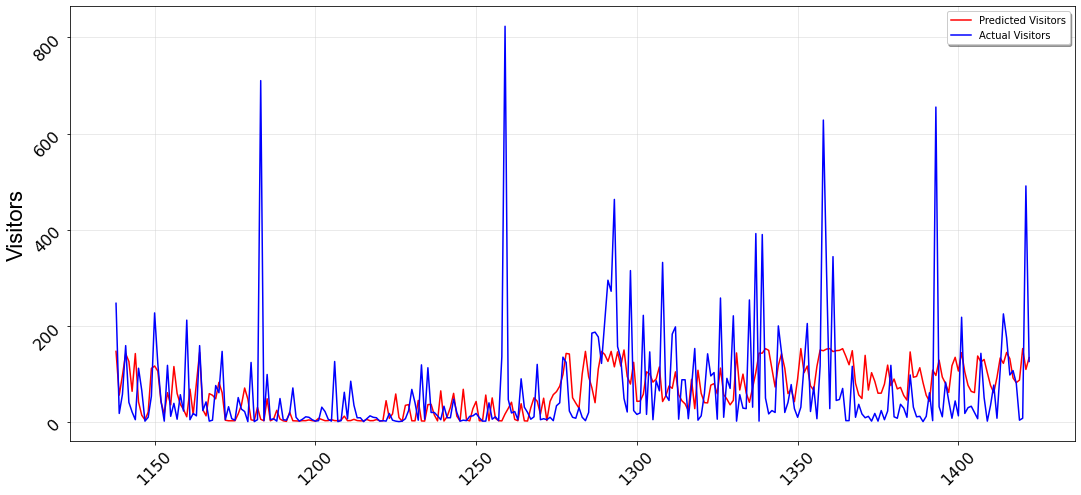

,Prediction,Actual
1138,146.988190,247
1139,56.055252,18
1140,97.430550,58
1141,142.248596,159
1142,126.052559,41
1143,63.991055,21
1144,142.497086,5
1145,41.841217,112
1146,14.305232,66
1147,4.571162,2


In [7]:
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2
from sklearn.metrics import mean_absolute_error

# create ANN model
model = Sequential()
 
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1]))
# model.add(Dropout(0.23))

# model.add(Dense(1024,activation='tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(512,activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))


model.add(Dense(np.sqrt(X_train.shape[1] * 3),activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(np.sqrt(X_train.shape[1] * 3),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
 
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=25, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0 )
mcp = ModelCheckpoint(filepath='weights_Tel_Arad.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=1000,verbose=0 ,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
clear_output(True)
model.load_weights('weights_Tel_Arad.h5')
prediction =model.predict(X_test_scaled)
print('')
res2 = pd.DataFrame(
    data={
        'Prediction':prediction.T[0],
        'Actual': y_test.values
    },
    index=y_test.index
)
print('mae', mean_absolute_error(res2.Prediction, res2.Actual))
print('rmse',function.get_rmse(res2.Prediction, res2.Actual))
print('std',np.std(res2.Actual))

res2.sort_index(inplace=True)
function.plot_line(res2.Prediction, res2.Actual)
res2.head(10)

In [8]:
rmse_str = str(np.round(function.get_rmse(res2.Prediction, res2.Actual),2))
import os 
# Check whether the specified path exists or not
path = site_name+'/'+rmse_str
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
model.save(path)

INFO:tensorflow:Assets written to: Tel Arad/110.34\assets


In [9]:
from keras.models import load_model
model = load_model('./Tel Arad/109.82')

from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

feature_index_list_selected=np.array(np.arange(12))
categorical_features = np.argwhere(
    np.array([len(set(X_train.values[:,x]))
    for x in range(X_train.shape[1])]) <= 10).flatten()
print(X_train.columns.shape)
print(categorical_features.shape)
print(X_train.shape)
explainer = LimeTabularExplainerOvr(X_train_scaled,
 feature_names=X_train.columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True, mode='regression',feature_selection='auto',feature_index_list_selected=feature_index_list_selected
 )

exp = explainer.explain_instance(X_test_scaled[13],model.predict,num_features=len(feature_index_list_selected))
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
exp.save_to_file('tel_arad_results.html')

(38,)
(37,)
(1138, 38)
lime_stability -- __init__ :feature_index_list_selected [ 0  1  2  3  4  5  6  7  8  9 10 11]
LimeTabularExplainer -- __init__ :feature_index_list_selected [ 0  1  2  3  4  5  6  7  8  9 10 11]


ValueError: in user code:

    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 39), found shape=(None, 38)
